In [1]:
#Import GPT2Tokenizer to use

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [2]:
import pickle
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from IPython.display import display
import sympy as sp
import urllib
sp.init_printing(use_latex=True)
import matplotlib.pyplot as plt
import textwrap
#import os
#os.environ['LD_LIBRARY_PATH']='/opt/conda/lib'

2023-06-27 18:04:00.040530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 18:04:00.101759: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
#Relative Mutli Head Attention from SirDavidLudwig's DeepDNA
#https://github.com/DLii-Research/deep-dna/tree/master

class RelativeMultiHeadAttention(keras.layers.MultiHeadAttention):
    def __init__(self, max_seq_len=None, **kwargs):
        super().__init__(**kwargs)
        self._max_seq_len = max_seq_len

    def build(self, input_shape):
        if self._max_seq_len is None:
            self._max_seq_len = input_shape[1]
            assert self._max_seq_len is not None, "RelativeMultiHeadAttention requires max_seq_len to be specified."
        self._rel_embeds = self.add_weight("relative_embeddings",
                                           shape=(self._max_seq_len, self._key_dim),
                                           initializer="glorot_uniform", trainable=True)
        return super().build(input_shape)

    def get_config(self):
        config = super().get_config()
        config.update({
            "max_seq_len": self._max_seq_len
        })
        return config

    def _skew(self, QEr):
        padded = tf.pad(QEr, [[0, 0], [0, 0], [0, 0], [1, 0]])
        shape = tf.shape(padded)
        reshaped = tf.reshape(padded, (shape[0], shape[1], shape[3], shape[2]))
        return reshaped[:,:,1:,:]

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        # Note: Applying scalar multiply at the smaller end of einsum improves
        # XLA performance, but may introduce slight numeric differences in
        # the Transformer attention head.
        query = tf.multiply(query, 1.0 / np.sqrt(float(self._key_dim)))

        # Compute relative position encodings
        rel_enc = self._skew(tf.einsum("acbd,ed->abce", query, self._rel_embeds))

        # Take the dot product between "query" and "key" to get the raw
        # attention scores.
        attention_scores = tf.einsum(self._dot_product_equation, key, query)

        attention_scores = self._masked_softmax(attention_scores + rel_enc, attention_mask)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)

        # `context_layer` = [B, T, N, H]
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores


In [4]:
# Transormer block setup
# Initializes Relative Multie Head Attention, feed-forward network, layer normalization
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        #Using David's Relative Multi Head Attention
        self.att = RelativeMultiHeadAttention(max_seq_len=max_seq_len, num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
             keras.layers.Dense(embed_dim), ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)




In [5]:
# Initialize transformer, Relative Multi-Head-Attention, feed forward, and causal mask
class GPTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, max_seq_len=None, **kwargs):
        super(GPTransformerBlock, self).__init__(**kwargs)
        #Using David's Relative Multi Head Attention
        self.att = RelativeMultiHeadAttention(max_seq_len=max_seq_len, num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
             keras.layers.Dense(embed_dim), ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, training):
        y = x
        y = self.layernorm1(y, training=training)
        y = self.att(y, y,
                     use_causal_mask=True,
                     training=training)
        y = self.dropout1(y, training=training)
        x += y
        y = x
        y = self.layernorm2(y, training=training)
        y = self.ffn(y, training=training)
        y = self.dropout2(y, training=training)
        return x + y


In [6]:
#Positional encoding for self-attention

# Source pulled from KerasNLP: https://github.com/keras-team/keras-nlp/blob/v0.4.1/keras_nlp/layers/sine_position_encoding.py#L22
class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    This layer optionally accepts `tf.RaggedTensor`s as inputs to process
    batches of sequences of different lengths. The one ragged dimension must be
    the dimension that corresponds to the sequence, that is, the penultimate
    dimension.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        if isinstance(inputs, tf.RaggedTensor):
            bounding_shape = inputs.bounding_shape()
            position_embeddings = (
                self._compute_trim_and_broadcast_position_embeddings(
                    bounding_shape,
                )
            )
            # then apply row lengths to recreate the same ragged shape as inputs
            return tf.RaggedTensor.from_tensor(
                position_embeddings,
                inputs.nested_row_lengths(),
            )
        else:
            return self._compute_trim_and_broadcast_position_embeddings(
                tf.shape(inputs),
            )

    def _compute_trim_and_broadcast_position_embeddings(self, shape):
        seq_length = shape[-2]
        hidden_size = shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

In [7]:
#Token and position embedding to allow the model to differentiate token positions, for self-attention
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, input_dim, output_dim, **kwargs):
        super(MaskedTokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = keras.layers.Embedding(input_dim=input_dim,
                                                output_dim=output_dim,
                                                mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
                                              output_dim=output_dim,
                                              mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [8]:
#Sine position embeddings, for self-attention
class MaskedTokenAndSinePositionEmbedding(keras.layers.Layer):
    def __init__(self, input_dim, output_dim, max_wavelength=10000,**kwargs):
        super(MaskedTokenAndSinePositionEmbedding, self).__init__(**kwargs)
        self.token_emb = keras.layers.Embedding(input_dim=input_dim,
                                                output_dim=output_dim,
                                                mask_zero=True)
        self.pos_emb = SinePositionEncoding(max_wavelength=max_wavelength)

    def call(self, x):
        mask = tf.expand_dims(tf.sign(x),-1)
        x = self.token_emb(x)
        positions = self.pos_emb(x)
        positions = positions * mask
        return x + positions

In [9]:
# Custom masked loss/accuracy functions
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


In [10]:
# !wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/Austen.txt

In [11]:
segment_size = 20
model_length = 10*segment_size
batch_size = 100

In [12]:
with open('Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
text = []
j = 0
for i in range(len(lines)-1):
    if lines[i] == '':
        line = ' '.join(lines[j:i])
        if line != '':
            text = text + [line[k:k+model_length-2] for k in range(0, len(line), model_length-2)]
            # text = text + [line]
        j = i+1

In [13]:
len(text)

In [14]:
text[0]

'Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world'

In [15]:
# Subset? - All of the data will take some time...
n_seq = len(text)
n_seq = 1000
split_point = int(n_seq * 0.8)
text = text[:n_seq]
np.random.shuffle(text) # In-place modification
max_length = np.max([len(i) for i in text])+2 # Start+stop
max_length

200

In [16]:
#Encode / Decode tokens using built-in functions

def encode_seq(x, tokenizer, max_length=0):
    #String to token IDs
    #Using end of text token as padding
    encoded = tokenizer.encode(x, max_length=max_length, truncation=False)
    padding = encoded + [50256 for i in range (max_length - len(encoded))]
    return padding

def decode_seq(x, tokenizer):
    #Token IDs to string
    remove_padding = []
    for i in range(len(x)):
        if x[i] == 50256: #end of text
            break
        remove_padding.append(x[i])
    return tokenizer.decode(remove_padding)

In [17]:
temp = encode_seq(text[0], tokenizer, max_length)
print(*temp)

88 783 290 788 11 290 339 318 1654 284 6594 832 790 1285 287 465 835 284 34612 13 679 468 3804 345 845 1690 526 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 

In [18]:
len(temp)

In [19]:
decoded_temp = decode_seq(temp, tokenizer)
print(decoded_temp)

y now and then, and he is sure to ride through every week in his way to Kingston. He has passed you very often."


In [61]:
"""
Pick random length (2 to max len)
Each of them select random starting point (within range)
Pick random index
"""

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, max_length, batch_size=32, **kwargs):
        super(DataGenerator, self).__init__(**kwargs)
        'Initialization'
        self.batch_size = batch_size
        self.data = data # a handle only...
        self.indices = np.arange(self.data[0].shape[0])
        self.max_length = max_length
        self.idx = 0
        self.on_epoch_end()

    def __len__(self):
        'The number of batches per epoch'
        return int(np.floor(self.data[0].shape[0] / self.batch_size))

    def __getitem__(self, index):
        #List indexing overload
        'Generate one (enumerated) batch of data'
        # Generate indices for a batch and grab batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        #random_indices = np.random.choice(self.indices, size = self.batch_size, replace = False, p = None)
        return self.__data_generation(indices)

    def __data_generation(self, ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Generate data
        random_length = np.random.randint(5, len(self.data[0][ids]))
        start_point = np.random.randint(0, random_length // 2) # Max range for the start point is half of the random length

        #Get the original sequences
        original_x = self.data[0][ids, start_point:start_point+random_length]
        original_y = self.data[1][ids, start_point:start_point+random_length]
        
        #Pad the sequences with the end padded token to ensure it is the correct length
        padded_x = np.pad(original_x, ((0, 0), (0, self.max_length - random_length)), constant_values=50256)
        padded_y = np.pad(original_y, ((0, 0), (0, self.max_length - random_length)), constant_values=50256)
        
        #Convert to tensors
        x = tf.convert_to_tensor(padded_x, dtype=tf.int32)
        y = tf.convert_to_tensor(padded_y, dtype=tf.int32)
        return x, y

    def on_epoch_end(self):
        return np.random.shuffle(self.indices)

    ## Needed for TF Dataset conversion...
    def output_signature(self):
        sig = self[0]
        return (tf.TensorSpec.from_tensor(sig[0]),
                tf.TensorSpec.from_tensor(sig[1]))

In [118]:
#Encode in batches
X = np.vstack([encode_seq(x,tokenizer,max_length + (segment_size - (max_length-1) % segment_size)) for x in text])
training = DataGenerator((X[:split_point,:-1],
                          X[:split_point,1:]),model_length,batch_size)
validation = DataGenerator((X[split_point:,:-1],
                            X[split_point:,1:]),model_length,batch_size)

In [119]:
print(decode_seq(training[0][0][0], tokenizer))
print()
print(decode_seq(training[0][0][0], tokenizer))
print()
print(decode_seq(training[0][0][0], tokenizer))
print()


 again. Oh dear, no! Mr. Weston, who had been a widower so long, and who seemed so perfectly

 had been a widower so long, and who seemed so perfectly comfortable without a wife, so constantly occupied either in his business in town or among hi

 Oh dear, no! Mr. Weston, who had been a widower so long, and who seemed so perfectly comfortable without a wife, so constantly occupied either in his business in town or among hi



In [111]:
training[0][0].shape

TensorShape([100, 200])

In [66]:
np.array([np.random.randint(i) for i in temp])-100

array([  -60,   501,    68,   610,  -100,   126,   179,   -38,   463,
         -80,  3440,   646,   260,   550,    10,    37,   303,   -73,
       26638,   -88,   -49,   -39,  3029,    31,   468,  1524,     6,
       49509,  8443, 20614,   859, 23878, 39202, 16844, 23889,  8539,
       42167, 50085, 12222, 10252, 47957, 28268,  5504, 14777, 16732,
       23474,  7703, 37475, 36518, 31478, 34998, 47167, 17765, 30498,
       45512, 29677,  9096,  6539, 43621, 35311, 24736,  6588, 26196,
         967, 25257, 35462, 15408, 14573, 11049, 36539, 23984, 17390,
       17149, 24625, 46845, 25059, 18419,  5591, 46282, 44420, 22458,
       28976, 45025, 29655, 16843, 39117,  2555, 24195, 18661, 25858,
       45590, 40959,  7145, 41259, 39127, 39439, 47301, 22587, 18697,
       43127, 16744, 26509, 26582, 39628,   558, 48129,  7366, 34554,
         747, 35278, 41986, 32884,  6266, 30148, 11258, 46780,  4257,
        6131, 22673,  5917, 20618, 16185, 11374, 15556, 13343, 12752,
       29433, 49956,

In [67]:
my_batch = training[0]
my_batch[0].shape

TensorShape([100, 200])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 masked_token_and_sine_posit  (None, None, 128)        6432896   
 ion_embedding (MaskedTokenA                                     
 ndSinePositionEmbedding)                                        
                                                                 
 gp_transformer_block (GPTra  (None, 200, 128)         883200    
 nsformerBlock)                                                  
                                                                 
 gp_transformer_block_1 (GPT  (None, 200, 128)         883200    
 ransformerBlock)                                                
                                                                 
 gp_transformer_block_2 (GPT  (None, 200, 128)         883200

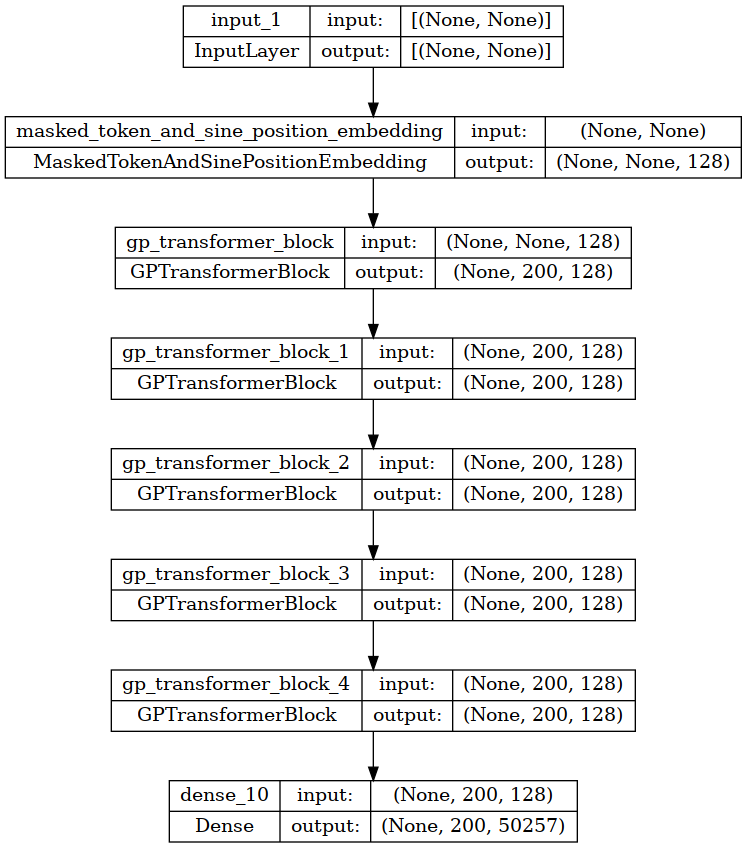

In [68]:
#Finalize and compile model
n_tokens = len(tokenizer)
embedding_size = 128
stack = 5
num_heads = 12
memory_size = segment_size * 3

y = x = keras.layers.Input((None,))
y = MaskedTokenAndSinePositionEmbedding(input_dim=n_tokens,
                                        output_dim=embedding_size)(y)
for _ in range(stack):
    y = GPTransformerBlock(embedding_size,
                           num_heads,
                           embedding_size*2,
                           max_seq_len = max_length)(y)

y = keras.layers.Dense(n_tokens)(y)

model = keras.Model(x,y)
model.compile(loss=MaskedSparseCategoricalCrossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=MaskedSparseCategoricalAccuracy)
model.summary()
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [449]:
epochs = 300
history = model.fit(training,
                    epochs=epochs,
                    validation_data=validation,
                    verbose=1)

Epoch 1/300
8/8 [==============================] - 9s 713ms/step - loss: 4.8493 - MaskedSparseCategoricalAccuracy: 0.7821 - val_loss: 1.2163 - val_MaskedSparseCategoricalAccuracy: 0.9273
Epoch 2/300
8/8 [==============================] - 5s 638ms/step - loss: 1.4607 - MaskedSparseCategoricalAccuracy: 0.8879 - val_loss: 2.4543 - val_MaskedSparseCategoricalAccuracy: 0.8501
Epoch 3/300


KeyboardInterrupt: 

In [200]:
model.save_weights("Keiningham-Random-Weights")

In [201]:
print('Training Accuracy:',model.evaluate(training)[1]*100.0,'%')
print('Validation Accuracy:',model.evaluate(validation)[1]*100.0,'%')

8/8 [==============================] - 2s 282ms/step - loss: 0.1830 - MaskedSparseCategoricalAccuracy: 0.9557
Training Accuracy: 95.56620121002197 %
2/2 [==============================] - 1s 281ms/step - loss: 1.2181 - MaskedSparseCategoricalAccuracy: 0.8797
Validation Accuracy: 87.97001242637634 %


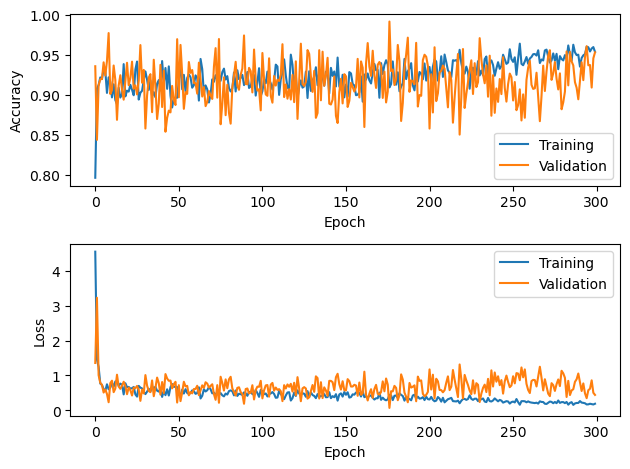

In [202]:
plt.figure(1)  
# summarize history for accuracy 
plt.subplot(211)  
plt.plot(history.history['MaskedSparseCategoricalAccuracy'])  
plt.plot(history.history['val_MaskedSparseCategoricalAccuracy'])  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Training','Validation'],loc='upper right')
plt.tight_layout()
plt.show()

In [203]:
# What should we see?
i = 0
print('Input:', training[0][0][i])
print('Output:', training[0][1][i])

Input: tf.Tensor(
[46442   813    11   475   345    11 18966   526 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50

In [204]:
# Teacher-forcing
result = model(training[0][0][i:i+1]).numpy()
result.argmax(-1)[0]

array([50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       50256, 50256,

In [206]:
decode_seq(result.argmax(-1)[0],tokenizer)

''

In [207]:
# How much agreement really? - remember masked tokens (0) don't count
MaskedSparseCategoricalAccuracy(training[0][1][i:i+1],result).numpy()*100.0

In [208]:
def select_token(x):
    x = np.cumsum(x)
    return np.argmin(x < np.random.random())

In [459]:
# Turn off teacher forcing...
# Prompt (needs to be at least 1 - the start token?...)
i = 2
data = training[0][0][i:i+1]
prompt = 4
tokens = np.full(data.shape,dtype=np.int32,fill_value=50256) #Courtesy of Parker Daniels
tokens[0,0:prompt] = data[:,0:prompt]

print("Original:")
print(decode_seq(data[0],tokenizer))
print()

print("Prompt:")
print(decode_seq(tokens[0],tokenizer))
print()

print("Decoding:")
print(decode_seq(tokens[0],tokenizer),end='')
for x in range(prompt,data.shape[1]-1):
    probabilities = keras.activations.softmax(model(tokens)).numpy()[0,x-1]
    # Most likely token...
    result = probabilities.argmax(-1)
    # Sampled token...
    result = np.apply_along_axis(select_token, -1, probabilities)
    tokens[0,x] = result
    if result == 50256:
        break # Stop token found!
    print(decode_seq(tokens[0,x:x+1],tokenizer),end='')
print()
print()

result = model(tokens).numpy()
print("Remodeled:")
print(decode_seq(result.argmax(-1)[0],tokenizer))

Original:
 do not make a stranger of me."

Prompt:
 do not make a

Decoding:
 do not make a their

Remodeled:



In [226]:
# Turn off teacher forcing...
# Prompt (needs to be at least 1 - the start token?...)
i = 3
data = training[0][0][i:i+1]
prompt = 5
tokens = np.full(data.shape,dtype=np.int32,fill_value=50256) #Courtesy of Parker Daniels
tokens[0,0:prompt] = data[:,0:prompt]

print("Original:")
print(decode_seq(data[0],tokenizer))
print()

print("Prompt:")
print(decode_seq(tokens[0],tokenizer))
print()

print("Decoding:")
print(decode_seq(tokens[0],tokenizer),end='')
for x in range(prompt,data.shape[1]-1):
    probabilities = keras.activations.softmax(model(tokens)).numpy()[0,x-1]
    # Most likely token...
    result = probabilities.argmax(-1)
    # Sampled token...
    result = np.apply_along_axis(select_token, -1, probabilities)
    tokens[0,x] = result
    if result == 50256:
        break # Stop token found!
    print(decode_seq(tokens[0,x:x+1],tokenizer),end='')
print()
print()

result = model(tokens).numpy()
print("Remodeled:")
print(decode_seq(result.argmax(-1)[0],tokenizer))

Original:
 to her friend that she saw, felt, anticipated, and remembered just as she ought. Mr. Elton's superiority had very ample acknowledgment.

Prompt:
 to her friend that she

Decoding:
 to her friend that she was not very kind on the subject."

Remodeled:
 be. in she could impossible perfectly much to the subject."


In [217]:
# Turn off teacher forcing...
# Prompt (needs to be at least 1 - the start token?...)
sample = "It is a truth universally acknowledged"
data = np.array(encode_seq(sample, tokenizer, max_length))
data = data.reshape(1,-1)
prompt = len(sample.split())
tokens = np.full(data.shape,dtype=np.int32,fill_value=50256) #Courtesy of Parker Daniels
tokens[0,0:prompt] = data[:,0:prompt]

print("Original:")
print(decode_seq(data[0],tokenizer))
print()

print("Prompt:")
print(decode_seq(tokens[0],tokenizer))
print()

print("Decoding:")
print(decode_seq(tokens[0],tokenizer),end='')
for x in range(prompt,data.shape[1]-1):
    probabilities = keras.activations.softmax(model(tokens)).numpy()[0,x-1]
    # Most likely token...
    result = probabilities.argmax(-1)
    # Sampled token...
    result = np.apply_along_axis(select_token, -1, probabilities)
    tokens[0,x] = result
    if result == 50256:
        break # Stop token found!
    print(decode_seq(tokens[0,x:x+1],tokenizer),end='')
print()
print()

result = model(tokens).numpy()
print("Remodeled:")
print(decode_seq(result.argmax(-1)[0],tokenizer))

Original:
It is a truth universally acknowledged

Prompt:
It is a truth universally acknowledged

Decoding:
It is a truth universally acknowledged of wanting. Not a thing of her. This will not have a great-loured and obliging last market.  

Remodeled:
 is a very. of of wanting. The _ little of his, This will articulate always the great regardhumoured and obliging High head you  


In [ ]:
!tar -cf Keiningham-Weights-2.tar Keiningham-Weights-2.*

In [ ]:
!tar xf Keiningham-Weights-2.tar